<div style="width: 100%; height: 50px; background-color: #000FFF"><h1 style="font-family: manrope; color: black; text-align: center; vertical-align: middle; line-height: 50px"><strong>Projeto Paraná Banco</strong></h1></div> </br>

<div style="color: black; font-family: sans-serif">
Nesta avaliação encaminhamos em anexo um arquivo compactado com dados em csv . A base de
dados apresenta informações fictícias sobre operações de clientes de uma instituição bancária. O
tempo previsto para execução desta atividade é de até 2h. </br>

Utilizando Python e Jupyter Notebook, faça as seguintes tarefas:</br>

<div style="color: black; font-family: sans-serif">
<h8> <strong>1. Faça uma análise inicial dos dados: você encontrou algum problema? Como você trataria
estes problemas?</strong></h8> </br>
   
       
<h8><strong>2. Faça uma análise exploratória dos dados: distribuições de variáveis, outliers, correlações,
etc.</strong></h8></br>


<h8> <strong>3. Faça uma projeção do crescimento da carteira para os próximos 2 anos em termos de
volume de operações e da carteira utilizando os métodos de ciência de dados que julgar
mais adequados para essa tarefa.</strong></h8></br>

Observações:</br>

1. Códigos em formato .ipynb, estruturado e bem documentado.
2. Durante a entrevista, realizaremos a revisão do código e questionamentos sobre suas ideias
e abordagens.

</div>
<br>


#### Bibliotecas utilizadas

In [306]:
#libs 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlretrieve
import plotly.express as px
import plotly.graph_objects as go

import sys
from typing import Dict, Tuple, List, Union
import json
import yaml
import random

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Configuração do Notebook
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None

#### Funcoes 

In [307]:
def corr_report(data, columns, min_corr=0.1):
    '''
    Realiza uma análise de correlação entre as variáveis do DataFrame.

    Parâmetros:
    data (pandas.DataFrame): O DataFrame contendo os dados.
    columns (list): Uma lista das colunas para incluir na análise de correlação.
    min_corr (float): O valor mínimo de correlação a ser considerado significativo.

    Retorna:
    tuple: Uma tupla contendo dois dicionários, um para correlações baixas e outro para correlações altas.

    Exemplo:
    >>> data = pd.DataFrame({
    ...     'A': [1, 2, 3, 4, 5],
    ...     'B': [2, 4, 6, 8, 10],
    ...     'C': [3, 6, 9, 12, 15]
    ... })
    >>> low_corr, high_corr = corr_report(data, ['A', 'B', 'C'], min_corr=0.5)
    >>> low_corr
    {'Coluna1': [], 'Coluna2': [], 'Correlação': []}
    >>> high_corr
    {'Coluna1': ['A'], 'Coluna2': ['B'], 'Correlação': [1.0]}
    '''
    corr = data[columns].corr()
    high_corr = {'Coluna1':[], 'Coluna2':[], 'Correlação':[]}
    low_corr = {'Coluna1':[], 'Coluna2':[], 'Correlação':[]}
    skip_row = []
    for idx,col in enumerate(corr.columns):
        skip_row.append(idx)
        for row in range(len(corr.columns)):
            if row in skip_row:
                continue
            if abs(round(corr.iloc[idx, row], 4)) > min_corr:
                high_corr['Coluna1'].append(col)
                high_corr['Coluna2'].append(corr.columns[row])
                high_corr['Correlação'].append(round(corr.iloc[idx, row], 4))
            else:
                low_corr['Coluna1'].append(col)
                low_corr['Coluna2'].append(corr.columns[row])
                low_corr['Correlação'].append(round(corr.iloc[idx, row], 4))
                
    # Plotagem de um exemplo com as colunas quantitativas discretas
    sns.pairplot(data[columns])
    plt.show()

    return low_corr, high_corr

def check_cols(data, columns):
    df_check = pd.DataFrame(zip(data[columns].dtypes.index, 
                                data[columns].dtypes, 
                                data[columns].nunique(), 
                                data[columns].isna().sum(),
                                round(data[columns].isna().sum()/data.shape[0], 3)*100), 
                            columns=['Variável', 'Tipo', 'Qtde_unicos', 'Qtde_NaN', '%_NaN'])
    return df_check.sort_values('Qtde_NaN').reset_index().drop('index', axis=1)

def plot_serie(df):
    import plotly.express as px
    import plotly.graph_objects as go

    # Se o DataFrame não estiver lendo a coluna "ds" como datetime, você pode convertê-la usando:
    # df_metricas_resultado_geral['ds'] = pd.to_datetime(df_metricas_resultado_geral['ds'])

    # Criar um intervalo de datas mensais que cubra o período completo de dados
    min_date = df['data_operacao'].min()
    max_date = df['data_operacao'].max()
    date_range = pd.date_range(start=min_date, end=max_date, freq='M')

    # Criar o gráfico interativo usando o plotly
    fig = px.line(df, x='data_operacao', y='y_pred', color='Model', markers=True)
    # Definir a opacidade das outras linhas para 0.5 (50% opaco)
    fig.update_traces(opacity=0.5)
    # Adicionar a linha dos valores reais de "y"
    df_real = df[['data_operacao', 'valor_bruto']].drop_duplicates()
    fig.add_trace(go.Scatter(x=df_real['data_operacao'], y=df_real['valor_bruto'], mode='lines+markers', name='Valor Real de "valor_bruto"', line=dict(color='rgb(228,26,28)')))

    # Definir o eixo x com o intervalo de datas mensais
    fig.update_xaxes(tickvals=date_range)

    # Definir o formato da data no eixo x
    fig.update_layout(xaxis_tickformat='%b %Y')

    # Definir os limites do eixo y para começar em 0
    fig.update_yaxes(range=[0, df['valor_bruto'].max()])

    # Definir os títulos e rótulos do eixo
    fig.update_layout(title='Valores Previstos (y_pred) e Valores Reais (valor_bruto) ao longo do tempo para cada modelo',
                    xaxis_title='Data (data_operacao)',
                    yaxis_title='Valor')

    # Exibir o gráfico interativo
    fig.show()

def get_juros(item):
    """
    Calcula o valor total dos juros para um item específico com base no valor principal, taxa de contrato e quantidade de parcelas.

    Parâmetros:
    item (pandas.Series): Uma linha de um DataFrame contendo as colunas 'valor_principal', 'taxa_contrato' e 'quantidade_parcelas'.

    Retorna:
    float: O valor total dos juros calculado com base no valor principal, taxa de contrato e quantidade de parcelas.

    Exemplo:
    >>> row = {'valor_principal': 1000, 'taxa_contrato': 5, 'quantidade_parcelas': 12}
    >>> get_juros(row)
    61.03515625
    """
    return item['valor_principal'] * (1 + item['taxa_contrato'] / 1200) ** item['quantidade_parcelas']

def properties(data, cols):
    """
    Exibe as propriedades estatísticas das colunas quantitativas de um DataFrame.

    Parâmetros:
        data (DataFrame): O DataFrame contendo os dados.
        cols (list): Uma lista de strings com os nomes das colunas quantitativas.

    Retorna:
        None

    Exemplo de uso:
        properties(df, ['valor_principal', 'idade', 'valor_parcela'])
    """
    for col in cols:
        print(col + ":",
              "min:", data[col].min(),
              "max:", data[col].max(),
              "mean:", data[col].mean(),
              "median:", data[col].median(),
              "mode:", data[col].mode().values[0])
        
def plot_grouped_bar(dataframe, metrica):
    # Definir a cor laranja (#FF7628) para o modelo "Predição_Cliente"
    colors = ['#FF7628' if model == 'Predição_cliente' else '#7A7423' for model in dataframe['Model']]

    fig = px.bar(dataframe, x='Model', y=metrica, color='Model', color_discrete_sequence=colors,
                 text=metrica, labels={'Model': 'Modelo', metrica: f'{metrica.upper()} (%)'})

    fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')

    fig.update_layout(title=f'Comparação do {metrica.upper()}',
                      xaxis_title='Modelo',
                      yaxis_title=f'{metrica.upper()} (%)',
                      xaxis_tickangle=-45)

    fig.show()

def plot_serie(df):

    # Se o DataFrame não estiver lendo a coluna "ds" como datetime, você pode convertê-la usando:
    # df_metricas_resultado_geral['ds'] = pd.to_datetime(df_metricas_resultado_geral['ds'])

    # Criar um intervalo de datas mensais que cubra o período completo de dados
    min_date = df['data_operacao'].min()
    max_date = df['data_operacao'].max()
    date_range = pd.date_range(start=min_date, end=max_date, freq='M')

    # Criar o gráfico interativo usando o plotly
    fig = px.line(df, x='data_operacao', y='y_pred', color='Model', markers=True)
    # Definir a opacidade das outras linhas para 0.5 (50% opaco)
    fig.update_traces(opacity=0.5)
    # Adicionar a linha dos valores reais de "valor_bruto"
    df_real = df[['data_operacao', 'valor_bruto']].drop_duplicates()
    fig.add_trace(go.Scatter(x=df_real['data_operacao'], y=df_real['valor_bruto'], mode='lines+markers', name='Valor Real de "valor_bruto"', line=dict(color='rgb(228,26,28)')))

    # Definir o eixo x com o intervalo de datas mensais
    fig.update_xaxes(tickvals=date_range)

    # Definir o formato da data no eixo x
    fig.update_layout(xaxis_tickformat='%b %Y')

    # Definir os limites do eixo y para começar em 0
    fig.update_yaxes(range=[0, df['valor_bruto'].max()])

    # Definir os títulos e rótulos do eixo
    fig.update_layout(title='Valores Previstos (y_pred) e Valores Reais (valor_bruto) ao longo do tempo para cada modelo',
                    xaxis_title='Data (data_operacao)',
                    yaxis_title='Valor')

    # Exibir o gráfico interativo
    fig.show()

#stats

def fisher_seasonality_test(data, num_seasons):
    from scipy.stats import f
    """
    Realiza o teste de sazonalidade de Fisher para determinar se há uma diferença significativa na variabilidade
    entre as estações.

    Parâmetros:
    - data: Uma série temporal ou conjunto de dados com uma estrutura de data, onde a sazonalidade será testada.

    Retorna:
    - f_statistic: A estatística de teste F.
    - p_value: O valor p associado ao teste de sazonalidade de Fisher.
    
    O teste de sazonalidade de Fisher compara a variabilidade dentro das estações com a variabilidade entre as 
    estações. Se o valor p for menor que um nível de significância escolhido (por exemplo, 0.05), rejeita-se a
    hipótese nula de que não há diferença significativa na variabilidade entre as estações, indicando a presença
    de sazonalidade nos dados.
    """
    # Dividir os dados em grupos correspondentes a cada estação
    season_groups = np.array_split(data, num_seasons)
    
    # Calcular a variabilidade dentro de cada estação (soma dos quadrados dos desvios em cada estação)
    sum_squares_within = sum(np.var(group) * len(group) for group in season_groups)
    
    # Calcular a variabilidade entre as estações (soma dos quadrados das médias das estações)
    grand_mean = np.mean(data)
    sum_squares_between = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in season_groups)
    
    # Graus de liberdade
    df_within = len(data) - num_seasons
    df_between = num_seasons - 1
    
    # Calculo da estatística de teste
    f_statistic = (sum_squares_between / df_between) / (sum_squares_within / df_within)
    
    # Calculo do valor p
    p_value = 1 - f.cdf(f_statistic, df_between, df_within)
    
    return f_statistic, p_value

# definindo uma diferenciacao. Pega-se o valor de vendas atrual e subtrai o valor de vendas do mesmo mes do ano anterior, ja a inversao
# recebe os dados ja diferenciados e devolve os dados na escala original para que seja verificado como que sai o modelo e entender a distancia entre o valor real e predito.
# É importante a diferenciacao visto que a serie tem sazonalidade e é nao estacionaria. 

def difference(dataset, interval=1):
    """
    Calcula a diferença entre os valores de um conjunto de dados.

    Parâmetros:
    - dataset: Lista/array de valores a serem diferenciados.
    - interval: Número de períodos para calcular a diferença. Padrão é 1.

    Retorna:
    - Lista contendo as diferenças calculadas.
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

def inverse_difference(history, prediction, interval=1):
    """
    Calcula a inversa da diferença entre a previsão e o histórico.

    Parâmetros:
    - history: Lista/array dos valores históricos.
    - prediction: Valor previsto pelo modelo.
    - interval: Número de períodos para calcular a inversa da diferença. Padrão é 1.

    Retorna:
    - Valor previsto na escala original.
    """
    return prediction + history[-interval]

#### 1. Aquisicão dos dados

In [308]:
df = pd.read_csv('/home/marina/paranaue/results/dados_operacoes.csv', sep=",") 
print(f'{df.shape[0]} linhas e {df.shape[1]} colunas')

14895 linhas e 24 colunas


In [309]:
# verificando os tipos das colunas, quantidades de nan e calculando a % de nan em cada uma delas
check_cols(df, df.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,id,object,4998,0,0.00
1,contrato,int64,14895,0,0.00
2,data_operacao,object,1457,0,0.00
3,nascimento,object,4099,0,0.00
4,idade,object,34,0,0.00
5,genero,object,3,0,0.00
6,bairro,object,483,0,0.00
7,cidade,object,1533,0,0.00
8,estado,object,28,0,0.00
9,cep,object,1782,0,0.00


In [310]:
df.sample(5)

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,telefone,cartao,email,ocupacao,empregador,operacao,valor_principal,parcelas,quantidade_parcelas,parcelas_pagas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
12496,0fc555a4c7021611565f32a19d9eac198da79944,5062640681211,2022-08-29,1973-03-22,50,M,São Cristóvão,das Neves,Null,XXXXX146,Null,XXXXXXXXXX22251,XXXXXXlho@pXXXXXXXXXXXX,Promotor de eventos,2acb21b4122944d51d02cfc6638212d897ca2719,Refin,570.35,60,60,15,15,3.44,22.57,1354.20
5217,1293e6c5bdd87dd7c4777fa9b0a1e26f38e9f7f2,322187615885,2021-07-30,1985-07-01,37,M,Vila Real 2ª Seção,Ribeiro Verde,Rondônia,XXXXX513,XXXXXXXXXXXXX11-2917,XXXXXXXXXX766436,Null,Lubrificador de máquinas,3b5c09777363fffec04355ebc23773c5a770c62d,Refin,12583.91,60,60,9,9,1.14,290.60,17436.00
12394,b263c36a2c1741e8642919ddfe26dd17c3ba3984,9033468860412,2021-03-15,1991-01-04,32,F,Grajaú,Santos,Tocantins,XXXXX537,XXXXXXXXXXXXX-9008,XXXXXXXXXX71489,XXXXXXXXXXl70@gXXXXXXXX,Agente comunitário de saúde,Null,Prod,13783.26,40,40,4,4,0.63,391.09,15643.60
10756,169cc8dc359b049c8c597e88fa1c595e1001a1d9,1889599314939,2020-02-01,1989-01-16,34,Null,Pindorama,da Cruz Paulista,Null,XXXXX-966,Null,Null,XXXXXiro@sXXXXXXXXXXXX,Cortador de cana-de-açucar,dbd11749e5df84038c433150932bd9d18afc1d5e,Prod,24223.70,40,40,2,2,0.86,717.62,28704.80
7038,664dc9f63134b87757a9e6531fea507b63b4daef,4478604867767,2019-06-13,2001-11-23,21,Null,Lagoa,Nunes,Null,XXXXX-823,XXXXXXXXXXXXX18-8824,XXXXXXXXXX372298034,XXXsus@aXXXXXXXXXXXX,Null,Null,Prod,42645.42,100,100,10,10,2.95,1329.21,132921.00


De cara podemos obervar que os dados em branco contém uma palavra escrita Null, o que acontece em varios bancos de dados. Essa palavra é interpretada como valor, portanto aparentemente está tudo preenchido e não temos falta de informação. Mas temos e o dado está sendo mascarado pelas palavras. Remover e substituir por valores vazios:

In [311]:
df.head()

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,telefone,cartao,email,ocupacao,empregador,operacao,valor_principal,parcelas,quantidade_parcelas,parcelas_pagas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
0,682e8b505c30bb12052f9457516dc47e7eafc8ed,1760865030954,2019-09-13,1974-06-08,48,F,Conjunto Paulo Vi,Moreira,Rio de Janeiro,XXXXX-685,XXXXXXXXXXXXX2797,Null,XXXXa51@mXXXXXXXXXXXX,Espeleologista,e53d5342e82e0ce6061bc3aaea1a986f24a73613,Prod,27810.69,100,100,20,20,1.46,531.56,53156.00
1,45ad9d444a276407df8b6f47c0fcc5b127dadaaa,6023030871505,2022-11-03,1988-07-23,34,F,Minas Caixa,da Mota de Azevedo,Amapá,XXXXX735,Null,XXXXXXXXXX562960,XXXXXXXXXXXnda@tXXXXXXXXXXXX,Mágico,f715ffaf2c8294df43df3357c6a37f04b900fb06,Refin,9589.96,40,40,6,6,4.54,523.82,20952.80
2,81cec74ea2ca41535fee03daeb410ddbdf12906a,560263027614,2021-06-13,1975-08-17,Null,Null,Vila Mantiqueira,Rocha da Prata,Santa Catarina,XXXXX863,XXXXXXXXXXXXX1-3076,XXXXXXXXXX55,Null,Null,da9515ffa45dd12791be0941b91188e51fe1cc04,Prod,42963.20,100,100,10,10,1.45,815.71,81571.00
3,4e987d9178e2dcb07c2bf3878736233a676a0a87,1397061435926,2021-08-30,1982-08-17,40,F,Anchieta,da Mata,Null,Null,Null,Null,Null,Conferente de carga e descarga,0c1741dc26339e6af3e4b6badcf984d383d1ca44,Port + Refin,2954.14,120,120,6,6,1.83,60.96,7315.20
4,595943ecdb32a24ccb6ef374b6d865f3b60d7130,3823566005671,2022-11-16,1985-07-14,37,F,Conjunto Floramar,Moreira de Goiás,Mato Grosso,XXXXX384,XXXXXXXXXXXXX7089,Null,Null,Treinador,f97b240dc24290c19e717d7a654747aa31722ad3,Prod,31186.17,100,100,10,10,3.28,1066.11,106611.00


In [312]:
df.replace("Null", np.nan, inplace=True)
#exemplo checagem
df.idade

0         48
1         34
2        NaN
3         40
4         37
        ... 
14890     28
14891     28
14892     28
14893     39
14894     39
Name: idade, Length: 14895, dtype: object

In [313]:
check_cols(df, df.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,id,object,4998,0,0.00
1,contrato,int64,14895,0,0.00
2,data_operacao,object,1457,0,0.00
3,nascimento,object,4099,0,0.00
4,operacao,object,3,0,0.00
5,quantidade_parcelas,int64,6,0,0.00
6,parcelas,int64,6,0,0.00
7,valor_principal,float64,14875,0,0.00
8,valor_bruto,float64,14571,0,0.00
9,valor_parcela,float64,14227,0,0.00


Agora sim tem-se as estatisticas corretas da tabela: a coluna cartao detém a maior porcentagem de valores nulos, batento mais de 35%. </br>
A coluna que tem a menor quantidade de valores nulos é a coluna de gênero, contando com 10% dela sem preenchimento. </br>
Geralmente colunas como gênero e idade trazer vieses aos modelos (de classificacao, por exemplo). O estado pode demonstrar um vies no numero de produtos adiquiridos também, </br> 
mas não consigo afirmar isso porque nao sei a real disponibilidade do banco em cada estado. Seria ela homogenea? Provavelmente não. </br>
Dados como telefone e email chegam a mais de 31% de falta de dados. Isso é um pouco alarmante quando se trata de um banco. Quando essas pessoas atrasam suas parcelas, como são encontradas? </br>
Para corrigir isso é necessário verificar o processo de coleta desses dados. Em algum momento  está falhando em obter esses dados ou eles estao se perdendo no caminho.


In [314]:
cols_obj = [x for x in df.select_dtypes(include=['object']).columns]

cols_num = [x for x in df.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns]

print(f'Total colunas tipo objeto: {len(cols_obj)}\nTotal de colunas tipo numerica: {len(cols_num)}')

Total colunas tipo objeto: 15
Total de colunas tipo numerica: 9


#### 2. Tratamento e analise dos dados

Tratamento básicos dos dados:

In [315]:
# Colunas que devem ser do tipo data
cols_dat = ['data_operacao', 'nascimento']

# Transformando em datetime para melhor visualização
for col in cols_dat:
    df[col] = pd.to_datetime(df[col])

# Colunas que devem ser do tipo objeto mas estao como int
cols_cod = ['contrato']

# Convertendo int para string
for col in cols_cod:
    df[col] = df[col].astype(str)
# bloco montado usualmente para mais de uma coluna.

In [316]:
# Notei que algumas colunas de parcelas podem estar duplicadas. Verificação:

# Igualdade entre parcelas e quantidade_parcelas
igualdade_parcelas = df['parcelas'].equals(df['quantidade_parcelas'])

# Igualdade entre parcelas_pagas e quantidade_parcelas_pagas
igualdade_parcelas_pagas = df['parcelas_pagas'].equals(df['quantidade_parcelas_pagas'])

print("Igualdade entre parcelas e quantidade_parcelas:", igualdade_parcelas)
print("Igualdade entre parcelas_pagas e quantidade_parcelas_pagas:", igualdade_parcelas_pagas)

Igualdade entre parcelas e quantidade_parcelas: True
Igualdade entre parcelas_pagas e quantidade_parcelas_pagas: True


A constatação da duplicação foi feita, portanto "drop" das colunas repetidas para não atrapalhar as análises.

In [317]:
df = df.drop(columns=['parcelas', 'parcelas_pagas']).copy()

In [318]:
# apos tratamentos muito basicos para analise, verificando como esta a tabela atualmente:
check_cols(df, df.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,id,object,4998,0,0.00
1,contrato,object,14895,0,0.00
2,data_operacao,datetime64[ns],1457,0,0.00
3,nascimento,datetime64[ns],4099,0,0.00
4,operacao,object,3,0,0.00
5,quantidade_parcelas_pagas,int64,37,0,0.00
6,quantidade_parcelas,int64,6,0,0.00
7,valor_principal,float64,14875,0,0.00
8,taxa_contrato,float64,14626,0,0.00
9,valor_parcela,float64,14227,0,0.00


In [319]:
df['juros_calculados'] = df.apply(get_juros, axis=1)
df['previsto_a_pagar'] = df['valor_principal'] + df['juros_calculados']
df.head(5)

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,telefone,cartao,email,ocupacao,empregador,operacao,valor_principal,quantidade_parcelas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto,juros_calculados,previsto_a_pagar
0,682e8b505c30bb12052f9457516dc47e7eafc8ed,1760865030954,2019-09-13,1974-06-08,48,F,Conjunto Paulo Vi,Moreira,Rio de Janeiro,XXXXX-685,XXXXXXXXXXXXX2797,NaN,XXXXa51@mXXXXXXXXXXXX,Espeleologista,e53d5342e82e0ce6061bc3aaea1a986f24a73613,Prod,27810.69,100,20,1.46,531.56,53156.00,31419.34,59230.03
1,45ad9d444a276407df8b6f47c0fcc5b127dadaaa,6023030871505,2022-11-03,1988-07-23,34,F,Minas Caixa,da Mota de Azevedo,Amapá,XXXXX735,NaN,XXXXXXXXXX562960,XXXXXXXXXXXnda@tXXXXXXXXXXXX,Mágico,f715ffaf2c8294df43df3357c6a37f04b900fb06,Refin,9589.96,40,6,4.54,523.82,20952.80,11152.09,20742.05
2,81cec74ea2ca41535fee03daeb410ddbdf12906a,560263027614,2021-06-13,1975-08-17,NaN,NaN,Vila Mantiqueira,Rocha da Prata,Santa Catarina,XXXXX863,XXXXXXXXXXXXX1-3076,XXXXXXXXXX55,NaN,NaN,da9515ffa45dd12791be0941b91188e51fe1cc04,Prod,42963.20,100,10,1.45,815.71,81571.00,48467.59,91430.79
3,4e987d9178e2dcb07c2bf3878736233a676a0a87,1397061435926,2021-08-30,1982-08-17,40,F,Anchieta,da Mata,NaN,NaN,NaN,NaN,NaN,Conferente de carga e descarga,0c1741dc26339e6af3e4b6badcf984d383d1ca44,Port + Refin,2954.14,120,6,1.83,60.96,7315.20,3546.54,6500.68
4,595943ecdb32a24ccb6ef374b6d865f3b60d7130,3823566005671,2022-11-16,1985-07-14,37,F,Conjunto Floramar,Moreira de Goiás,Mato Grosso,XXXXX384,XXXXXXXXXXXXX7089,NaN,NaN,Treinador,f97b240dc24290c19e717d7a654747aa31722ad3,Prod,31186.17,100,10,3.28,1066.11,106611.00,40985.48,72171.65


Esse bloco é importante: como não tenho essa informação e nem como conseguir a informação sobre o calculo dos juros e das taxas de contrato, considerei a fórmula do <a href="https://www.bv.com.br/bv-inspira/orientacao-financeira/juros-simples-e-composto#:~:text=%2D%20A%20f%C3%B3rmula%20dos%20juros%20simples,montante%20de%20juros%20do%20per%C3%ADodo. " target="_blank"> BV </a> de juros compostos e cheguei perto do resultado apresentado na coluna valor_bruto. Mas houve uma variação na co;luna calculada que pode ser por várias razoes: calculei a taxa de juros incorreta, falta informação sobre o pagamento das parcelas (se houve amortização entre outras operações ali no meio que mudem o valor final bruto do contrato, etc). Para uma análise mais profunda dos clientes, seriam importante ter o historico de pagamento dos contratantes. Seria interessante perfilar os que mais atrasam, os que costumam adiantar o pagamento, os que costumam adiquirir mais de um empréstimo, etc.

In [320]:
df.describe()

,data_operacao,nascimento,valor_principal,quantidade_parcelas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto,juros_calculados,previsto_a_pagar
count,14895,14895,14895.00,14895.00,14895.00,14895.00,14895.00,14895.00,14895.00,14895.00
mean,2021-03-19 01:18:01.087613184,1986-02-28 07:51:41.148036288,23185.88,68.22,15.74,2.13,724.27,47446.57,26492.03,49677.91
min,2019-01-01 00:00:00,1970-01-03 00:00:00,203.55,40.00,0.00,0.35,3.05,252.40,222.36,428.52
25%,2020-03-30 00:00:00,1978-01-24 12:00:00,12484.05,40.00,6.00,1.02,336.70,20689.50,14113.68,26727.80
50%,2021-05-12 00:00:00,1986-05-07 00:00:00,20256.79,60.00,9.00,1.79,601.64,38220.00,23490.63,44021.57
75%,2022-03-14 00:00:00,1994-04-23 00:00:00,34651.28,90.00,18.00,3.02,1007.65,61545.20,39206.78,74242.04
max,2022-12-30 00:00:00,2001-12-22 00:00:00,49995.02,120.00,108.00,6.46,3063.99,367678.80,91960.03,141776.59
std,NaN,NaN,13500.84,27.13,17.52,1.34,515.07,39877.20,15864.81,29170.30


In [321]:
quant_cols_discretas = ['quantidade_parcelas', 'quantidade_parcelas_pagas',]
quant_cols_continuas = ['valor_principal', 'valor_bruto', 'previsto_a_pagar', 'juros_calculados']
quant_cols_perc = ['taxa_contrato']
quant_cols_val_parc = ['valor_parcela']

In [322]:
properties(df, quant_cols_continuas)
properties(df, quant_cols_discretas)
properties(df, quant_cols_perc)
properties(df, quant_cols_val_parc)

valor_principal: min: 203.55 max: 49995.02 mean: 23185.87546559248 median: 20256.79 mode: 3249.9
valor_bruto: min: 252.4 max: 367678.8 mean: 47446.56859740249 median: 38220.0 mode: 4500.0
previsto_a_pagar: min: 428.52070588293 max: 141776.59233272227 mean: 49677.90975206635 median: 44021.5679980359 mode: 428.52070588293
juros_calculados: min: 222.35930925188225 max: 91960.03233272226 mean: 26492.03428647387 median: 23490.632110249622 mode: 222.35930925188225
quantidade_parcelas: min: 40 max: 120 mean: 68.22423632091306 median: 60.0 mode: 40
quantidade_parcelas_pagas: min: 0 max: 108 mean: 15.739039946290701 median: 9.0 mode: 6
taxa_contrato: min: 0.34737 max: 6.46168 mean: 2.1347009117153406 median: 1.7937 mode: 0.53187
valor_parcela: min: 3.05 max: 3063.99 mean: 724.2674481369587 median: 601.64 mode: 406.09


<strong>Falando um pouco sobre as estatísticas básicas de cada coluna quantitativa:</strong></br>

<strong>valor_principal</strong>: O desvio padrão é de aproximadamente 13500.84 unidades monetárias. Considerando que o valor médio está em torno de 23185.88, o desvio padrão é significativo em relação à média, o que sugere uma dispersão considerável dos valores de principal das operações. O que é normal para esse tipo de variavel que indica o valor concedido aos cientes e isso pode variar bastante mesmo. A mediana nao se distancia tanto, pode ser que nao haja tanto outlier na concessão de empresticos. </br>

<strong>quantidade_parcelas</strong>: Com um desvio padrão de cerca de 27.13, em relação a uma média de aproximadamente 68.22, a dispersão dos números de parcelas é relativamente baixa em comparação com outras variáveis. A mediana está em 60, relativamente proximo da media. </br>

<strong>quantidade_parcelas_pagas</strong>: O desvio padrão é de aproximadamente 17.52, em relação a uma média de 15.74. Isso indica uma dispersão moderada dos números de parcelas pagas mas está bem proximo da média. Já a mediana está em 9, o que pode indicar a presença de outliers.</br>

<strong>taxa_contrato</strong>: Com um desvio padrão de cerca de 1.34, em relação a uma média de 2.13, a dispersão dos valores das taxas de contrato é relativamente baixa mas a mediana está em 1.79, o que pode indicar a presença de ouliers.</br>

<strong>valor_parcela</strong>: O desvio padrão é de aproximadamente 515.07 unidades monetárias. Considerando que a média está em torno de 724.27, a dispersão dos valores das parcelas é significativa em relação à média. A mediana está em 601.64 unidades monetárias, o que pode indicar a presença de outliers.</br>

<strong>valor_bruto</strong>: Com um desvio padrão de cerca de 39877.20 unidades monetárias, em relação a uma média de 47446.57, a dispersão dos valores brutos das operações é bastante significativa. A mediana está em 38220 unidades monetárias, o que nos traz a possivel incidencia de outliers. No caso do valor bruto deve mudar bastante visto que variaveis no caminho podem afetar seu valor (dependendo do produto).</br>

<strong>juros_calculados</strong>: O desvio padrão é de aproximadamente 15864.81. Em relação a uma média de 26492.03, a dispersão dos valores dos juros calculados é bastante significativa e a mediana nem tanto, esta em torno de 23490.63. </br>

<strong>previsto_a_pagar</strong>: Com um desvio padrão de cerca de 29170.30 unidades monetárias, em relação a uma média de 49677.91, a dispersão dos valores previstos a pagar é bastante significativa, porém, sua mediana é de 44021 unidades monetárias. Comparando valor_bruto com previsto_a_pagar (meu calculo), temos um desvio padrao bem maior. </br>

In [323]:
df_disc = df[quant_cols_discretas]
df_cont = df[quant_cols_continuas]
df_perc = df[quant_cols_perc]
df_valparc = df[quant_cols_val_parc]

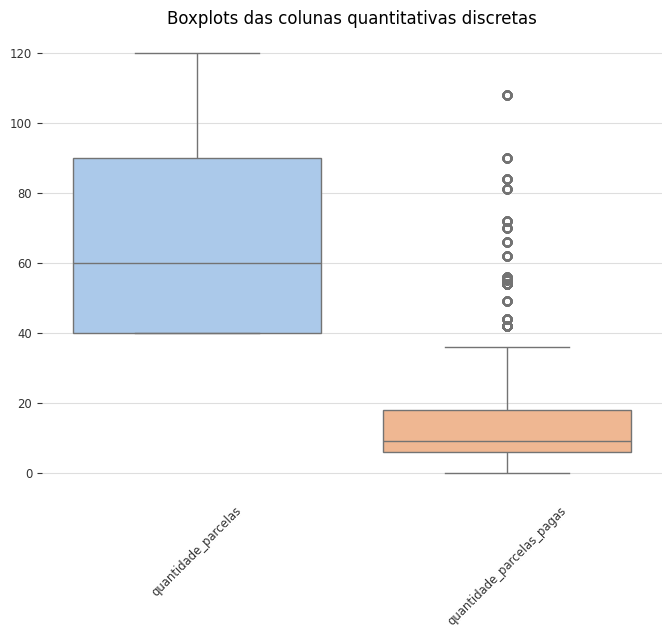

In [324]:
# Definir paleta de cores claras
sns.set_palette("pastel")

# Plotar boxplots das colunas quantitativas discretas
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_disc)
plt.title('Boxplots das colunas quantitativas discretas')
plt.xticks(rotation=45)  
plt.show()

Como pode-se ver, a quatidade de parcelas diverge bastante da quantidade de parcelas pagas, o que era de se esperar. Mas nas parcelas pagas é possivel notar grande presença de outliers.

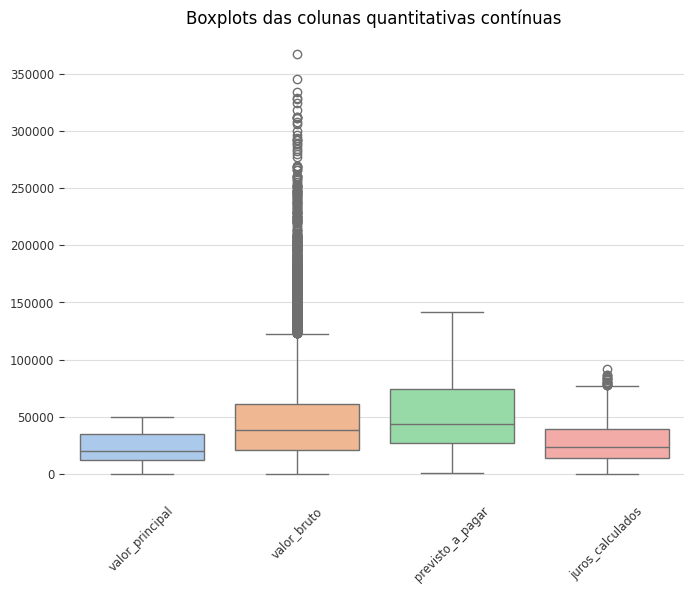

In [325]:
# Plotar boxplots das colunas quantitativas contínuas
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_cont)
plt.title('Boxplots das colunas quantitativas contínuas')
plt.xticks(rotation=45)  
plt.show()

Analisando as variaveis de valor a pagar, é possivel ver que valor bruto tem diversos outliers (conforme visto na analise estatistica acima). As outras variáveis comop valor principal e juros calculados apresentam comportamentos semelhantes e o previsto a pagar se assemelha em parte a variavel de valor bruto. 

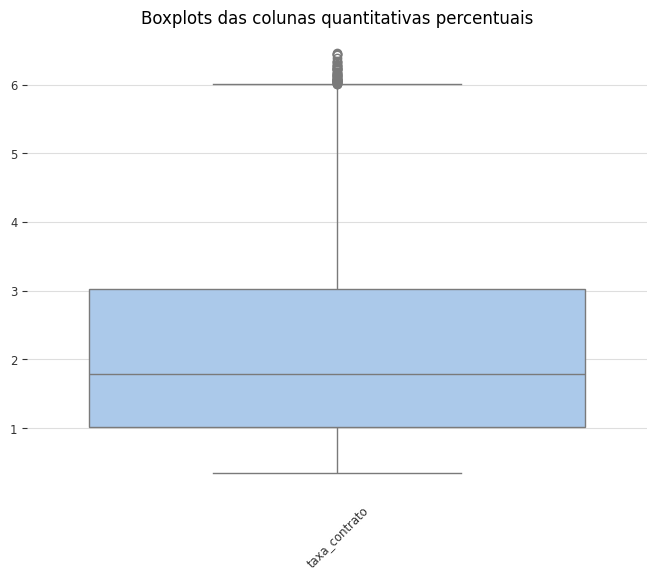

In [326]:
# Plotar boxplots das colunas quantitativas percentuais
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_perc)
plt.title('Boxplots das colunas quantitativas percentuais')
plt.xticks(rotation=45)  
plt.show()

Forte concentração dos valores da taxa do contrato se concentram em torno do 1 ao 3, tendo seu limite superior "esticado", apresentando a distancia entre o quartil 1 e 2 menor que o quartil 2 e 3. valores discrepantes altos.

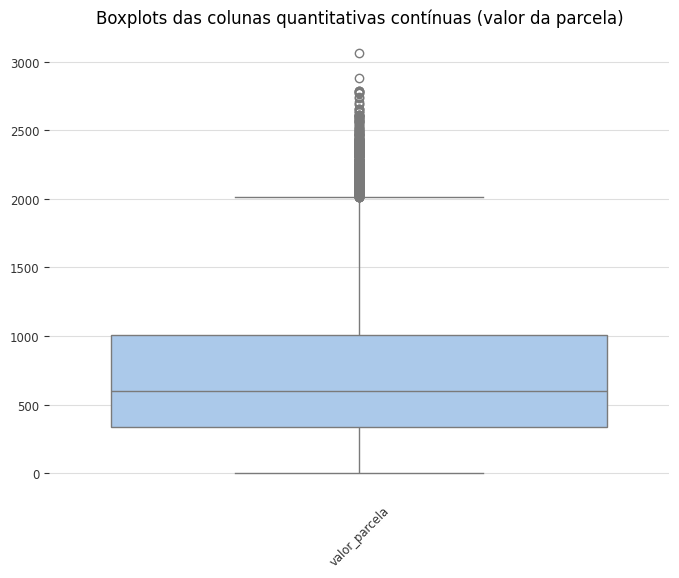

In [327]:
# Plotar boxplots das colunas quantitativas contínuas (valor da parcela)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_valparc)
plt.title('Boxplots das colunas quantitativas contínuas (valor da parcela)')
plt.xticks(rotation=45)  
plt.show()

O mesmo pode-se dizer do valor da parcela praticado, mas a Linha superior está menos "esticada". Muitos outliers que podem ter correlação com variaveis de pagamento, atraso, adiantamento de pagamento, etc.

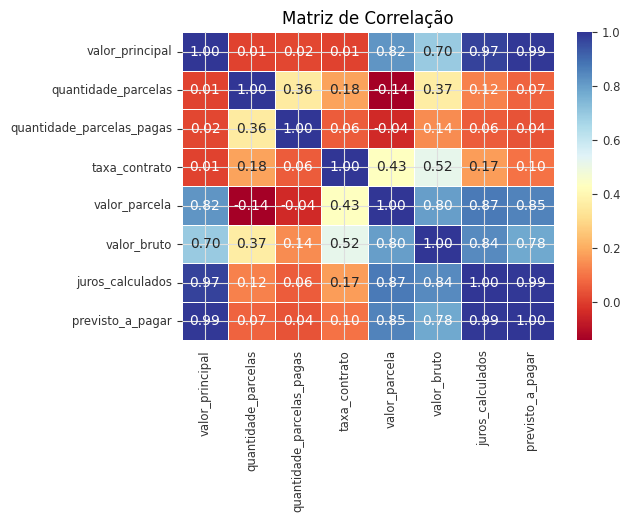

In [328]:
# Var Numericas
numbers = df.select_dtypes(include=['float64', 'int64'])

# Calculo da matriz de correlação
correlation_matrix = numbers.corr()

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()


<strong>Análise de correlações:</strong></br>

valor_principal -> Como é de se esperar para esse tipo de negocio, podemos ver que a variavel valor_principal tem forte correlação com o valor_parcela e o valor_bruto. Um "deriva" do outro, então é de se esperar que estejam correlacionados em algum ponto. As variaveis juros_calculados e previsto _a_pagar também apresentam fortissima correlação. </br>

quantidade_parcelas -> Está pouco correlacionada com a quantidade_parcelas_pagas e isso é absolutamente normal. Não possui correlação muito significante com quaisquer varáveis quantitativas do conjunto de dados. </br>

quantidade_parcelas_pagas -> Essa variável também não apresenta forte correlação com nenhuma outra.</br>

taxa_contrato -> apresenta uma correlação significante com, claro, valor_parcela e valor_bruto. Ambas variaveis estão ligadas na sua construção, por regras de negócio.</br>

valor_parcela -> essa variável apresenta forte correlação com o valor_principal (valor concedido ao cliente). Conforme regra de negócio, podemos ver que ela apresenta uma correlação negativa com a quantidade_parcelas. Enquanto uma cresce a outra diminui, mas a correlação nao é tão significativa. A taxa_contrato é uma variavel de impacto positivo na valor_parcela. Temos uma correlação significante entre elas, mas mais significante ainda é a correlação positiva com o valor_bruto do contrato, os _juros_acumulados e o valor previsto_a_pagar.</br>

valor_bruto -> essa variavel tem uma correlação forte e natura com o valor_principal. Uma é calculada a partir da outra (suponho eu). Consequentemente ela tem correlação moderada com a quantidade_parcelas, maior com a taxa_contrato e muito forte com o valor_parcela, juros_calculados e previsto_a_pagar. Tudo está interligado pelas regras de negócios. Sào valores e parcelamentos que se constroem a partir dessas variaveis, por isso a correlaçao forte. </br>

juros_calculados -> tem fortíssima correlação com o valor_principal, consequentemente tem fortissima correlação com valor_bruto, visto que podemos considerar um desdobramento do outro (calcuos a partir de). Também podemos ver que o valor_parcela, valor_bruto e previsto_a_pagar (desdobramento do calculo) também tem uma correlação imensa. Considero natural. </br>

previsto_a_pagar -> fortem,ente correlacionada com o valor_principal, valor_bruto e os juros_calculados. Curiosamente possui uma fraca correlação com a taxa_contrato, utilizada na sua construção. </br>

Abaixo uma outra forma de apresentar o mesmo mapa de calor:

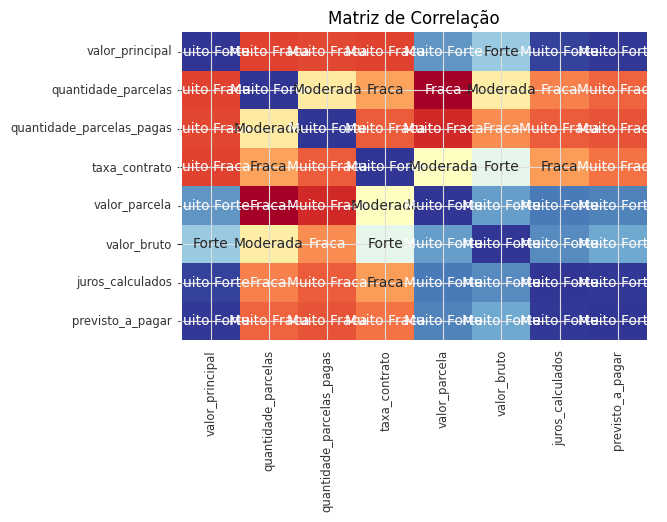

In [329]:
# Labels de interpretacao
labels = [
    ['Muito Forte', 'Forte', 'Moderada', 'Fraca'],
    ['Forte', 'Moderada', 'Fraca', 'Muito Fraca']
]

# Matriz de rótulos com base nos valores da matriz de correlação
labels_matrix = [['' for _ in range(len(correlation_matrix.columns))] for _ in range(len(correlation_matrix.columns))]

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        val = correlation_matrix.iloc[i, j]
        if val >= 0.7:
            labels_matrix[i][j] = labels[0][0]  # Muito forte - Positiva
        elif 0.5 <= val < 0.7:
            labels_matrix[i][j] = labels[0][1]  # Forte - Positiva
        elif 0.3 <= val < 0.5:
            labels_matrix[i][j] = labels[0][2]  # Moderada - Positiva
        elif 0.1 <= val < 0.3:
            labels_matrix[i][j] = labels[0][3]  # Fraca - Positiva
        elif -0.1 < val < 0.1:
            labels_matrix[i][j] = labels[1][3]  # Fraca - Negativa
        elif -0.3 < val <= -0.1:
            labels_matrix[i][j] = labels[1][2]  # Moderada - Negativa
        elif -0.5 < val <= -0.3:
            labels_matrix[i][j] = labels[1][1]  # Forte - Negativa
        elif val <= -0.7:
            labels_matrix[i][j] = labels[1][0]  # Muito forte - Negativa

# Heatmap com rótulos
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=labels_matrix, cmap='RdYlBu', fmt='', cbar=False)
plt.title("Matriz de Correlação")
plt.show()


In [330]:
# Mesmo grafico com label definido para auxiliar na leitura.

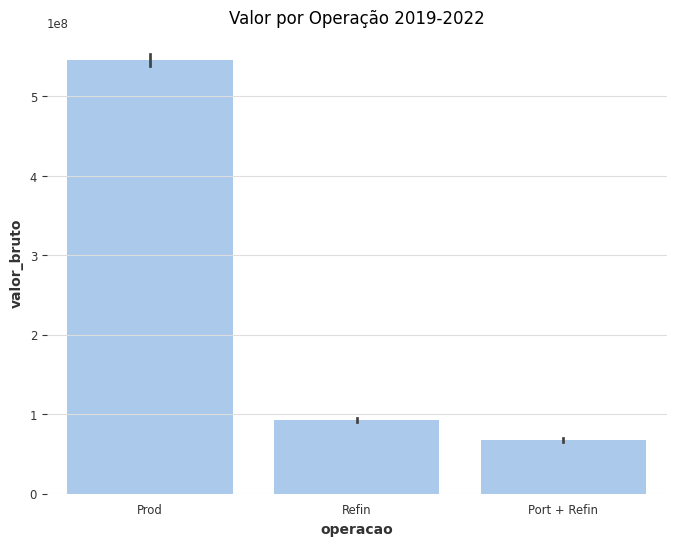

In [336]:
# 8. Distribuição de Vallores brutos por categoria
plt.figure(figsize=(8, 6))
sns.barplot(x='operacao', y='valor_bruto', data=df, estimator=sum)
plt.title('Valor por Operação 2019-2022')
plt.show()

O core business está em produtos próprios. 
Existe uma quantidade não tão grande de refinanciamentos e de poortabilidade   + Refinanciamento, o que pode significar um espaço de crescimento no campo de portabillidade, por exemplo. 
Trazer mais clientes de outros bancos para o Paraná Banco.

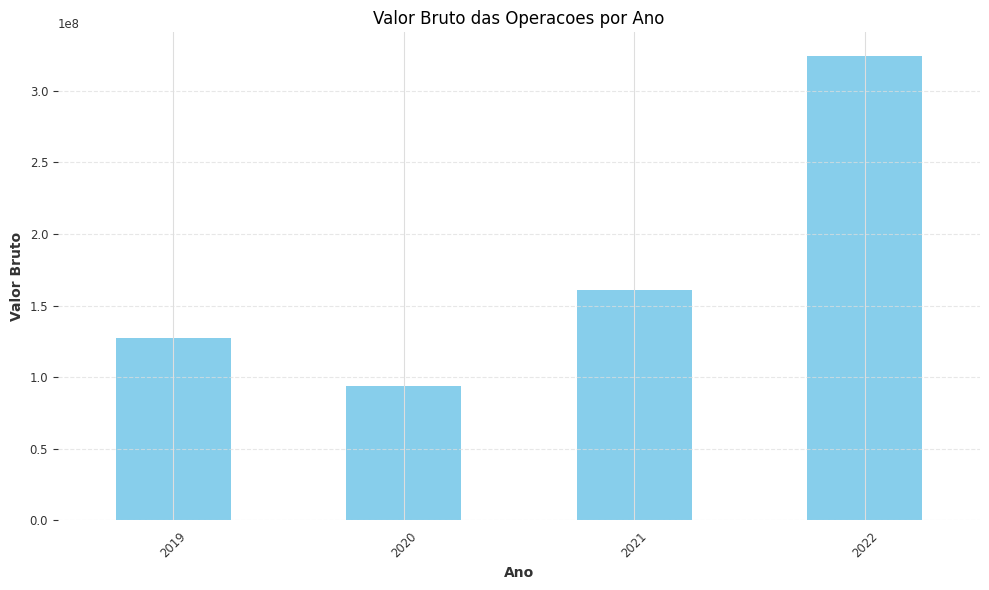

In [332]:
# Análise do Valor Bruto por Ano
df['ano'] = df['data_operacao'].dt.year
valor_bruto_por_ano = df.groupby('ano')['valor_bruto'].sum()

# Plotar o gráfico de barras para o valor bruto por ano
plt.figure(figsize=(10, 6))
valor_bruto_por_ano.plot(kind='bar', color='skyblue')
plt.title('Valor Bruto das Operacoes por Ano')
plt.xlabel('Ano')
plt.ylabel('Valor Bruto')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Ha uma evolucao nas vendas muito grande de 2021 a 2022. O crescimento nao segue um padrao definido nesse range de dados. Em 2020 o Banco teve uma queda nas operacoes (pandemia, provavelmente), em 2021 ja numa epoca pos pico grave e desconhecido da pandemia, houve um crescimento e ja em 2022 esse crescimento aumentou bastante em relacao aos outros anos.

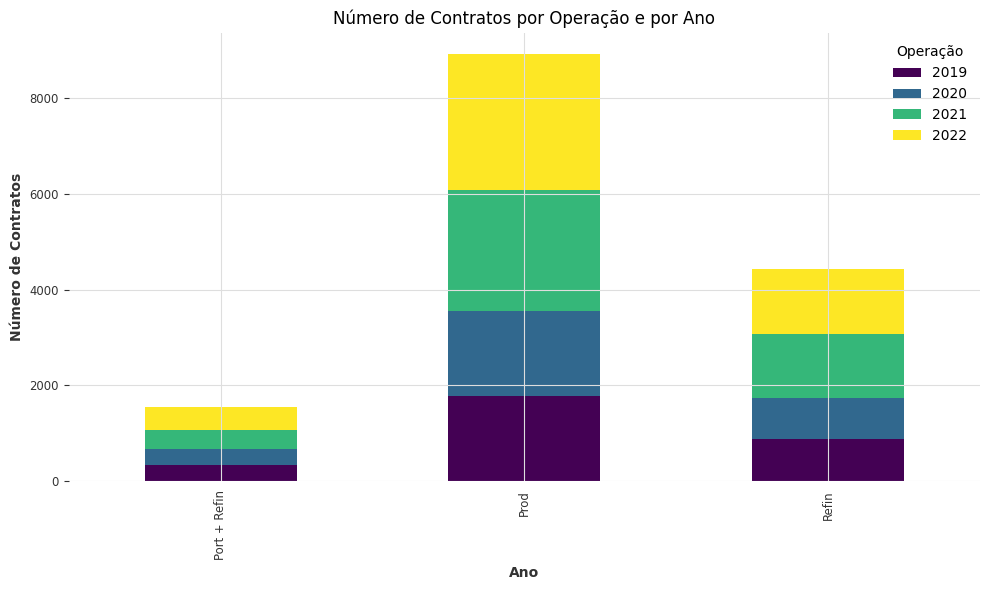

In [335]:
# Calculo do número de contratos por operação e por ano
contratos_por_operacao_ano = df.groupby(['operacao', 'ano']).size().unstack()

# Plotar o gráfico de barras empilhadas
contratos_por_operacao_ano.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Definir o título e os rótulos dos eixos
plt.title('Número de Contratos por Operação e por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Contratos')

# Mostrar a legenda
plt.legend(title='Operação')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


Pelo grafico podemos ver o crescimento de cada operacao ao longo dos anos disponiveis no df. O banco trabalha bastante com produtos proprios. Os dados apresentam a mesma distribuicao por ano, basicamente. O crescimento mais expressivo segue sendo puxado pela prod, acompanhado pelo refin e da port + refin.

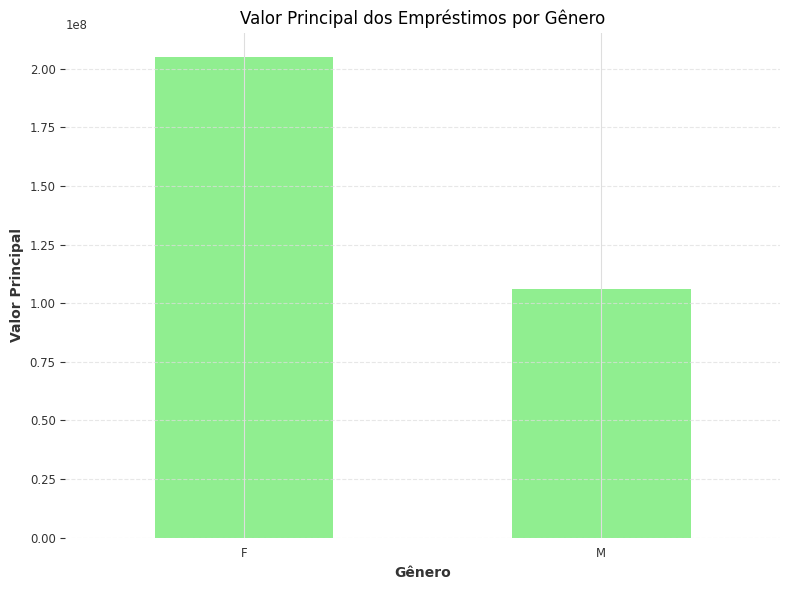

In [297]:
# Análise do Valor Principal por Gênero
valor_principal_por_genero = df.groupby('genero')['valor_principal'].sum()

# Plotar o gráfico de barras para o valor principal por gênero
plt.figure(figsize=(8, 6))
valor_principal_por_genero.plot(kind='bar', color='lightgreen')
plt.title('Valor Principal dos Produtos contratados por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Valor Principal')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

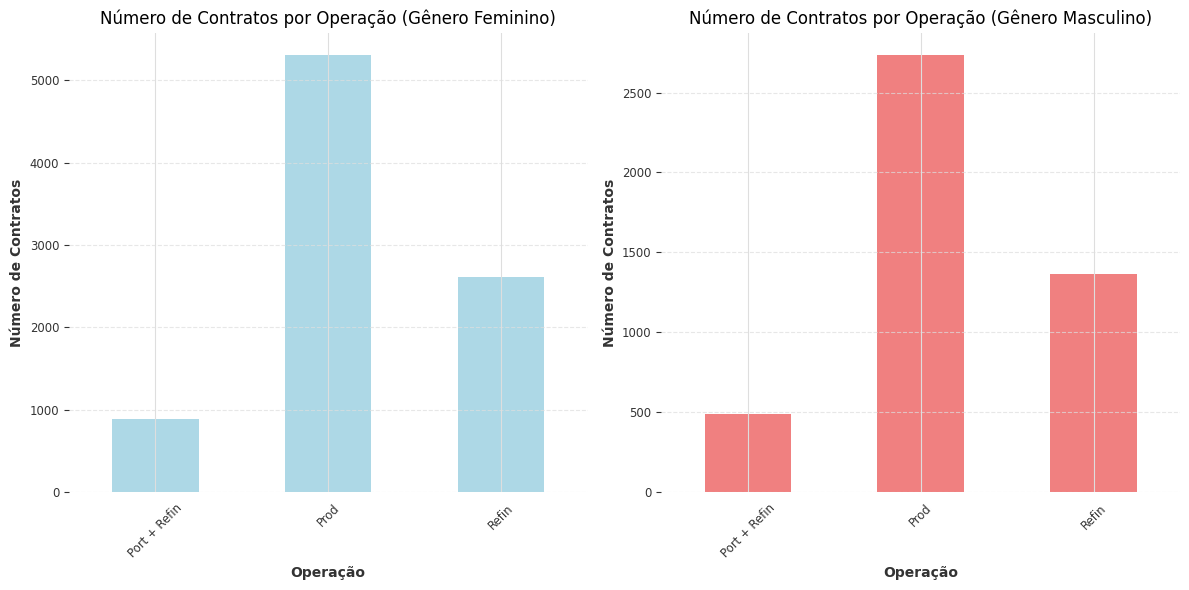

In [304]:
# Análise do Número de Contratos por Operação e por Gênero
contratos_por_operacao_genero = df.groupby(['operacao', 'genero']).size().unstack()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# gênero feminino
contratos_por_operacao_genero['F'].plot(kind='bar', color='lightblue', ax=ax[0])
ax[0].set_title('Número de Contratos por Operação (Gênero Feminino)')
ax[0].set_xlabel('Operação')
ax[0].set_ylabel('Número de Contratos')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].tick_params(axis='x', rotation=45)

# gênero masculino
contratos_por_operacao_genero['M'].plot(kind='bar', color='lightcoral', ax=ax[1])
ax[1].set_title('Número de Contratos por Operação (Gênero Masculino)')
ax[1].set_xlabel('Operação')
ax[1].set_ylabel('Número de Contratos')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Dentro do grupo do genero feminino, temos uma distribuicao muito parecida com o grupo masculino, mas em numeros diferentes. Existem varias maneiras de investigar melhor esse sucesso de vendas maior entre o genero feminino. Nessa reportagem do <a href="https://revistapegn.globo.com/Mulheres-empreendedoras/noticia/2020/11/mulheres-pedem-menos-credito-mas-instituicoes-financeiras-confiam-mais-nelas.html" target="_blank"> PEGN </a>, apesar das mulheres pedirem menos emprestimo que os homens, temos mais confianca das instituicoes financeiras na concessao de credito para o genero. Apesar de aparentar contradicao com os dados, a reportagem traz a informacao de que apesar de pedirem menos, conseguem mais credito devido ao fator de confiabilidade. Como os produtos financeiros da instituicao nao estao tao claros aqui, diria que esse fator por ter influencia mas nao e tudo. 

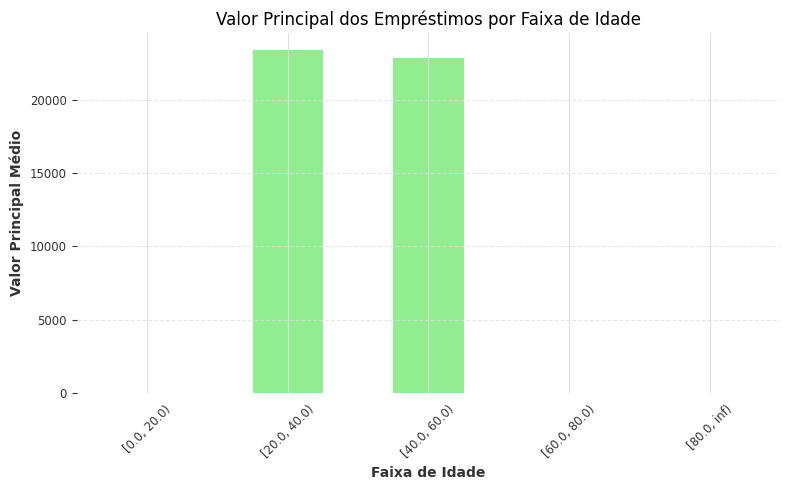

In [339]:
df['idade'] = pd.to_numeric(df['idade'], errors='coerce')

# Análise do Valor Principal por Faixa de Idade
faixas_idade = pd.cut(df['idade'], bins=[0, 20, 40, 60, 80, float('inf')], right=False)
df['faixa_idade'] = faixas_idade
valor_principal_por_faixa_idade = df.groupby('faixa_idade')['valor_principal'].mean()

# Plotar o gráfico de barras para o valor principal por faixa de idade
plt.figure(figsize=(8, 5))
valor_principal_por_faixa_idade.plot(kind='bar', color='lightgreen')
plt.title('Valor Principal dos Empréstimos por Faixa de Idade')
plt.xlabel('Faixa de Idade')
plt.ylabel('Valor Principal Médio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


A concentracao dos clientes do banco estao, majoritariamente entre as faixas de 20 a 60 anos, tendo uma concentracao maior ainda na faixa dos 20 aos 40. Isso pode ter relacao com adigitalizacao do banco, entre outros motivos economicos.

In [340]:
df.head(1)

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,telefone,cartao,email,ocupacao,empregador,operacao,valor_principal,quantidade_parcelas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto,juros_calculados,previsto_a_pagar,ano,faixa_idade
0,682e8b505c30bb12052f9457516dc47e7eafc8ed,1760865030954,2019-09-13,1974-06-08,48.00,F,Conjunto Paulo Vi,Moreira,Rio de Janeiro,XXXXX-685,XXXXXXXXXXXXX2797,NaN,XXXXa51@mXXXXXXXXXXXX,Espeleologista,e53d5342e82e0ce6061bc3aaea1a986f24a73613,Prod,27810.69,100,20,1.46,531.56,53156.00,31419.34,59230.03,2019,"[40.0, 60.0)"


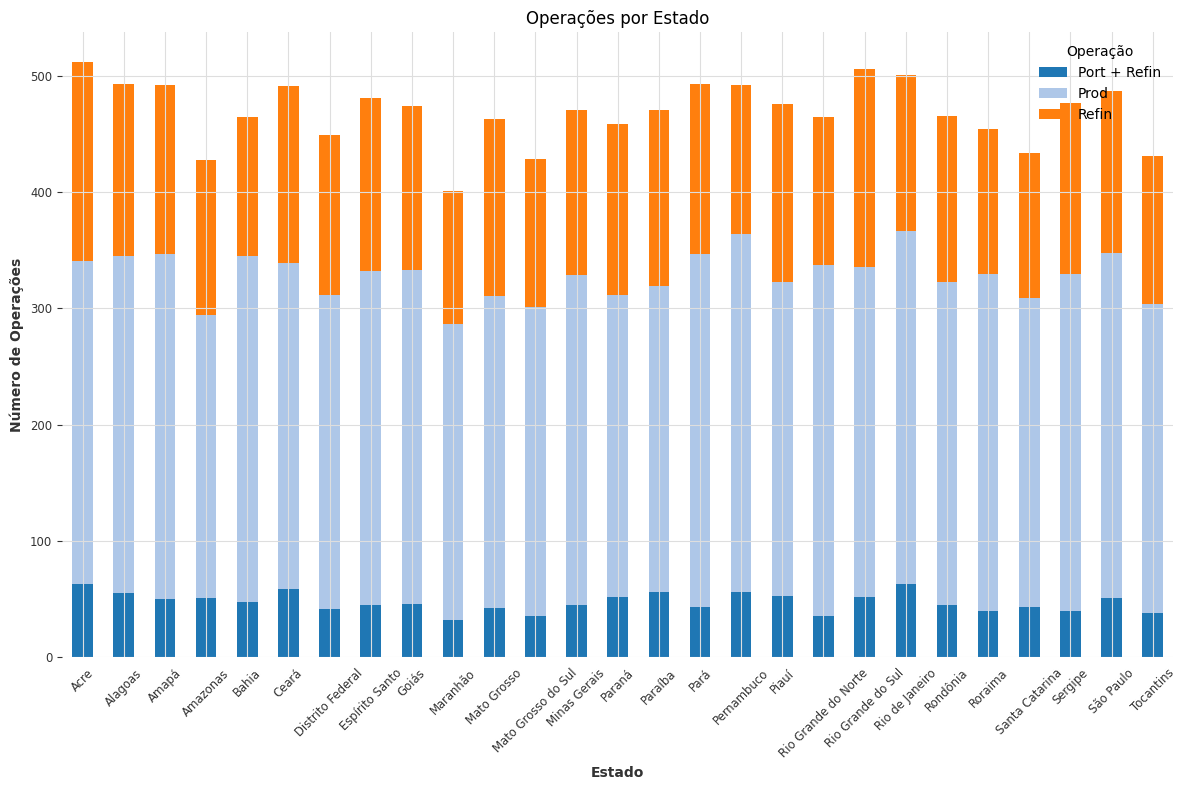

In [347]:
# 3. Análise do Número de Contratos por Operação e por Estado
cores = sns.color_palette("tab20", n_colors=27)

# Agrupar o DataFrame por estado e operação, contando o número de ocorrências
operacoes_por_estado = df.groupby(['estado', 'operacao']).size().unstack()

# Plotar o gráfico de barras empilhadas
operacoes_por_estado.plot(kind='bar', stacked=True, figsize=(12, 8), color=cores)
plt.title('Operações por Estado')
plt.xlabel('Estado')
plt.ylabel('Número de Operações')
plt.xticks(rotation=45)
plt.legend(title='Operação')
plt.tight_layout()
plt.show()

Por estado podemos ver que a distribuiução por tipo de operação não apresenta grandes mudanças. Continua tendo mais operação do tipo prod. É possível analisar os tipoos de operacao nos estados e traçar metas de crescimento dentro de cada um, mas para isso seria preciso entender mais profundamente os dados afim de verificar a possibilidade de expansão do mercado do Banco.

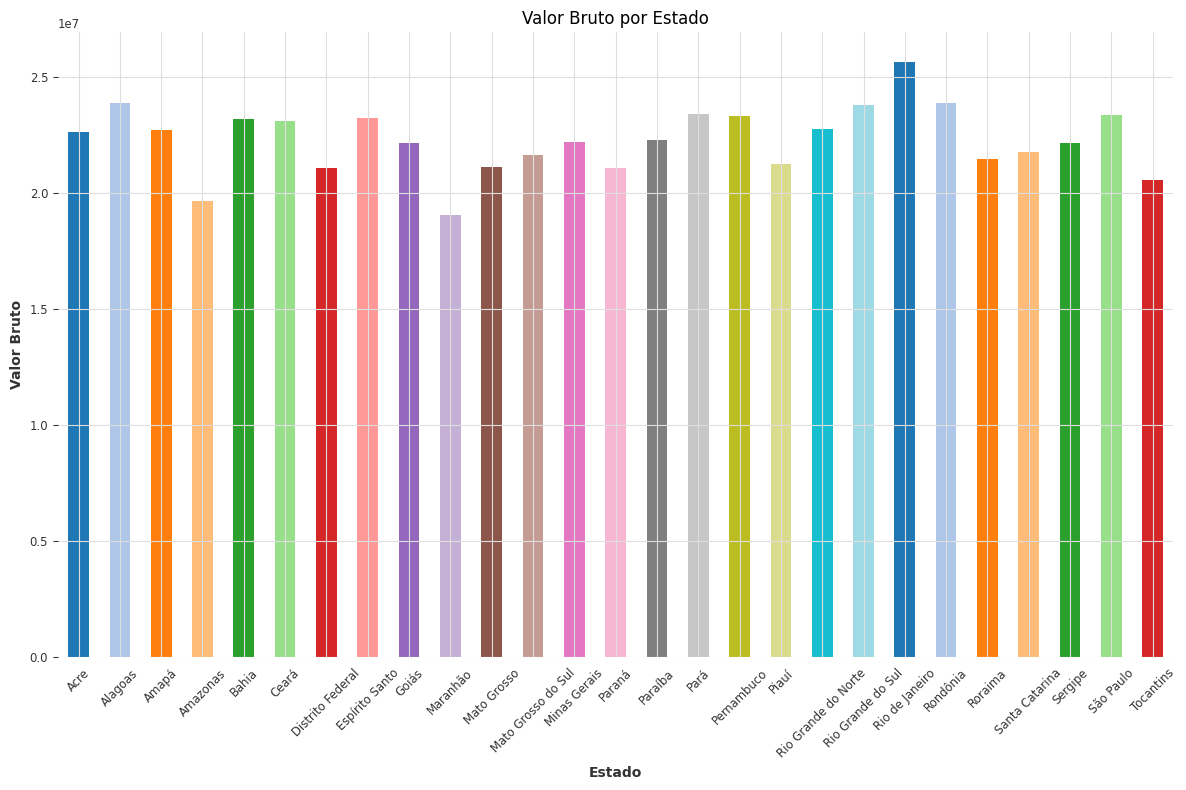

In [348]:
# Agrupar o DataFrame por estado e operação, somando o valor bruto
valor_bruto_por_estado = df.groupby('estado')['valor_bruto'].sum()

# Plotar o gráfico de barras empilhadas
valor_bruto_por_estado.plot(kind='bar', figsize=(12, 8), color=cores)
plt.title('Valor Bruto por Estado')
plt.xlabel('Estado')
plt.ylabel('Valor Bruto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Nos valores de contrato brutos por estado, podemos ver que curiosamente o Paraná não é tem a concentração maior de contratos ficando atrás de estados como o RS(sul) e PB(nordeste). O montante acompanha o numero de operacoes.

In [117]:
# Vamos primeiro agrupar por 'id' e contar o número de contratos
contratos_por_id = df.groupby(['id', 'operacao'])['contrato'].count()

# Agora, vamos filtrar os IDs que têm mais de um contrato
ids_mais_cont = contratos_por_id[contratos_por_id > 1]

ids_mais_cont.head(10)

id                                        operacao    
000c6067c4dd520edbb54c7cdc9eac485b78c738  Prod            3
                                          Refin           2
002a34ac68d3508d18a0b8f0e9b3a7d3ac29f485  Prod            4
                                          Refin           2
002d56e557d748768a2005d6703107cb1ff3dbc4  Prod            2
                                          Refin           3
003a4a60196dc6e46ac2d9235301ff59d5c174d7  Port + Refin    2
                                          Prod            4
004e9a2b1746b49cd75ba207f1ab66540af99a68  Prod            3
006d2351bbaa3f29e46066aec0a25b17731c4510  Prod            3
Name: contrato, dtype: int64

Foi identificada uma quantidade de ids que possuem mais de um contrato com tipos de operação diferentes ou mais de um item dentro da mesma operação. 
Significa que esse grupo de clientes tem uma relação maior com o banco. É interessante entender o que os fez adiquirir mais produtos aqui para que a técnica de venda seja replicada para outros clientes com perfis parecidos (modelos de uplift prediction, por exemplo). Falando um pouco sobre modelos de uplifting, a ideia desses modelos é identificar os indivíduos que são mais propensos a serem influenciados pela intervenção (respondedores) e aqueles que são menos propensos a serem influenciados ou até mesmo são prejudicados pela intervenção (não-respondedores). Diferente dos modelos tradicionais de previsão, que se concentram apenas em prever o resultado final, sem levar em consideração o efeito causal da intervenção. Podem ser adaptados para a realidade de um Banco.

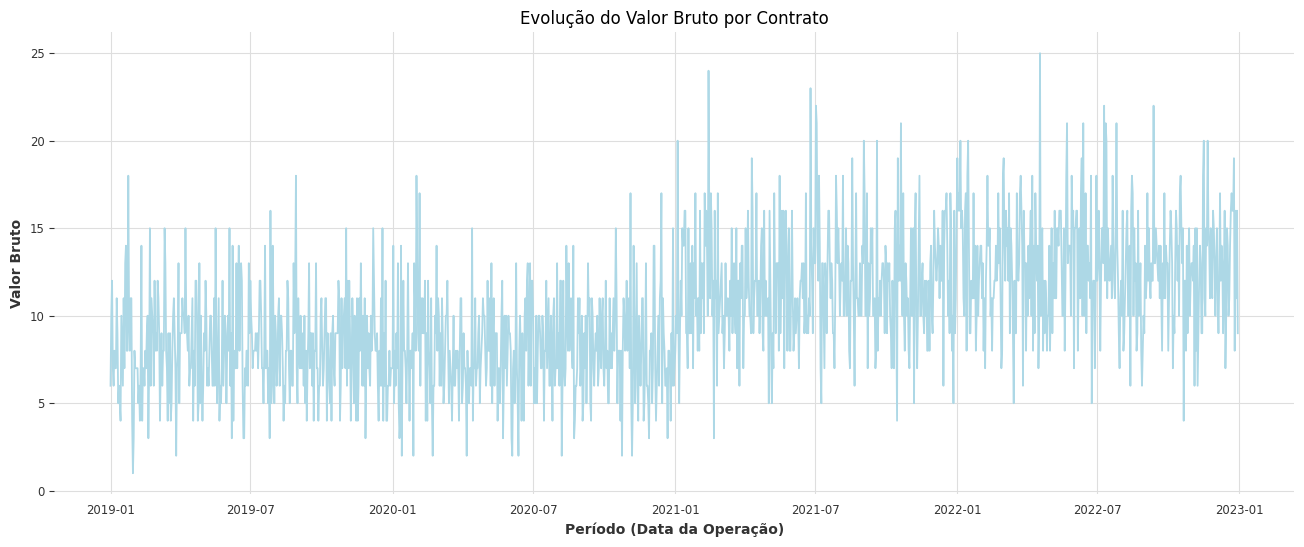

In [118]:
# Identificando evolução dos cancelamentos

df_plot = pd.DataFrame(df.groupby(['data_operacao'])['valor_bruto'].count()).reset_index()

plt.figure(figsize=[16,6])
sns.lineplot(
    x='data_operacao',
    y='valor_bruto',
    data=df_plot,
    color='#ADD8E6')
plt.xlabel('Período (Data da Operação)')
plt.ylabel('Valor Bruto')
plt.title('Evolução do Valor Bruto por Contrato')
plt.show()

del df_plot

#### 3. Series Temporais e Analises

In [119]:
PATH_TO_PARAMS = '/home/marina/paranaue/conf/params.yml'

In [120]:
PATH_TO_MODEL = '.'
PATH_TO_OUTPUT = '.'

In [121]:
DATE_COL = "data_operacao"
GROUP_COLS = "operacao"
VALUE_COLS = "valor_bruto"
STATIC_COLS = None     # Caso não haja colunas estáticas, alterar o valor para None

In [122]:
with open(PATH_TO_PARAMS, 'r') as fp:
    params = yaml.safe_load(fp)
params

{'next_steps': 12, 'freq': 'M'}

In [123]:
df_ts = df.copy()
pd.options.display.float_format = '{:.2f}'.format

In [124]:
df_pivot = (
        pd.pivot_table(
            data=df_ts,
            index="operacao",
            columns="data_operacao",
            values="valor_bruto",
            aggfunc="sum",
            fill_value=0,
        )
        .T.reindex(pd.date_range(df_ts["data_operacao"].min(), df_ts["data_operacao"].max(), freq="d"))
        .T.fillna(0)
    )
    # Resampling by week or month
df_pivot = df_pivot.resample(
        rule="M", label="right", closed="right", axis=1
    ).sum()

df_resample = df_pivot.reset_index().melt(
        id_vars=["operacao"], var_name="data_operacao", value_name="valor_bruto")

In [125]:
data = df_resample.copy()
data.head(40)

,operacao,data_operacao,valor_bruto
0,Port + Refin,2019-01-31 00:00:00,1382275.38
1,Prod,2019-01-31 00:00:00,8345793.80
2,Refin,2019-01-31 00:00:00,1471619.99
3,Port + Refin,2019-02-28 00:00:00,1034902.69
4,Prod,2019-02-28 00:00:00,7083400.20
5,Refin,2019-02-28 00:00:00,1051290.79
6,Port + Refin,2019-03-31 00:00:00,865828.51
7,Prod,2019-03-31 00:00:00,8062055.61
8,Refin,2019-03-31 00:00:00,1884984.60
9,Port + Refin,2019-04-30 00:00:00,1030646.10


In [126]:
data = data.fillna(0)

In [127]:
dates = data[DATE_COL].unique()

In [128]:
n_steps = params['next_steps'] 
freq = params['freq']

In [129]:
max_date_train = dates[-n_steps]
max_date_val = dates[-1]
print(max_date_val)
print(max_date_train)

2022-12-31 00:00:00
2022-01-31 00:00:00


In [130]:
data.head(10)

,operacao,data_operacao,valor_bruto
0,Port + Refin,2019-01-31,1382275.38
1,Prod,2019-01-31,8345793.80
2,Refin,2019-01-31,1471619.99
3,Port + Refin,2019-02-28,1034902.69
4,Prod,2019-02-28,7083400.20
5,Refin,2019-02-28,1051290.79
6,Port + Refin,2019-03-31,865828.51
7,Prod,2019-03-31,8062055.61
8,Refin,2019-03-31,1884984.60
9,Port + Refin,2019-04-30,1030646.10


In [131]:
df_train = data[(data[DATE_COL] < max_date_train)]
df_val = data[(data[DATE_COL] >= max_date_train) & (data[DATE_COL] <= max_date_val)]

3. Séries Temporais </br>
Nesse bloco farei uma análise das series tempororais e de modelos para projeção do crescimento das vendas e operações para 2 anos, conforme solicitado.

In [132]:
df_period = data

In [133]:
#transformando a data em index para criar as series temporais
df_period.set_index('data_operacao',inplace=True)
df_period.index = pd.DatetimeIndex(df_period.index).to_period('d')
df_period

,operacao,valor_bruto
data_operacao,,
2019-01-31,Port + Refin,1382275.38
2019-01-31,Prod,8345793.80
2019-01-31,Refin,1471619.99
2019-02-28,Port + Refin,1034902.69
2019-02-28,Prod,7083400.20
...,...,...
2022-11-30,Prod,19994062.28
2022-11-30,Refin,3653691.01
2022-12-31,Port + Refin,2704512.85


In [138]:
# Agrupar os valores pela data da operação e pela operação
df_ts_a = df_period.groupby(['data_operacao']).agg({'valor_bruto': 'sum'})
print(df_ts_a)

               valor_bruto
data_operacao             
2019-01-31     11199689.17
2019-02-28      9169593.69
2019-03-31     10812868.71
2019-04-30     12496544.51
2019-05-31     11467358.61
2019-06-30     11416683.72
2019-07-31     11738307.86
2019-08-31     11436868.49
2019-09-30      9596551.80
2019-10-31      9966509.26
2019-11-30      8907745.16
2019-12-31      9386419.09
2020-01-31      9662920.56
2020-02-29      9627644.07
2020-03-31      8406753.68
2020-04-30      7727724.68
2020-05-31      7690083.81
2020-06-30      7626235.18
2020-07-31      7684206.90
2020-08-31      7344905.67
2020-09-30      6826291.49
2020-10-31      7267220.72
2020-11-30      7332530.08
2020-12-31      6800200.21
2021-01-31     10318385.70
2021-02-28     10125926.93
2021-03-31     10542365.83
2021-04-30     11307235.79
2021-05-31     12083054.82
2021-06-30     11642715.32
2021-07-31     14148726.03
2021-08-31     13903655.60
2021-09-30     14637097.30
2021-10-31     15531532.79
2021-11-30     17658913.79
2

In [139]:
#separando as operacoes por dfs.

df_port_refin = data[data['operacao'] == 'Port + Refin']
df_port_refin = df_port_refin.drop(columns=['operacao'])
df_port_refin.head(10)

,valor_bruto
data_operacao,
2019-01-31,1382275.38
2019-02-28,1034902.69
2019-03-31,865828.51
2019-04-30,1030646.10
2019-05-31,1255913.59
2019-06-30,1077259.20
2019-07-31,1045881.81
2019-08-31,1466394.21
2019-09-30,1014835.40


In [140]:
df_prod = data[data['operacao'] == 'Prod']
df_refin = data[data['operacao'] == 'Refin']
df_refin = df_refin.drop(columns=['operacao'])
df_prod = df_prod.drop(columns=['operacao'])
df_refin.head(30)

,valor_bruto
data_operacao,
2019-01-31,1471619.99
2019-02-28,1051290.79
2019-03-31,1884984.60
2019-04-30,1215440.80
2019-05-31,1514669.30
2019-06-30,1464904.91
2019-07-31,1375241.70
2019-08-31,1447336.09
2019-09-30,1315588.11


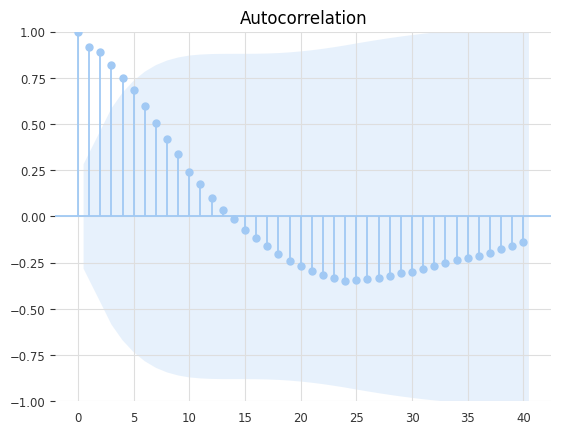

In [144]:
plot_acf(df_ts_a, lags=40)
pyplot.show()

Nesse grafico podemos identificar de maneira mais clara que até mais ou menos nivel 5 tem bastante autocorrelacao.

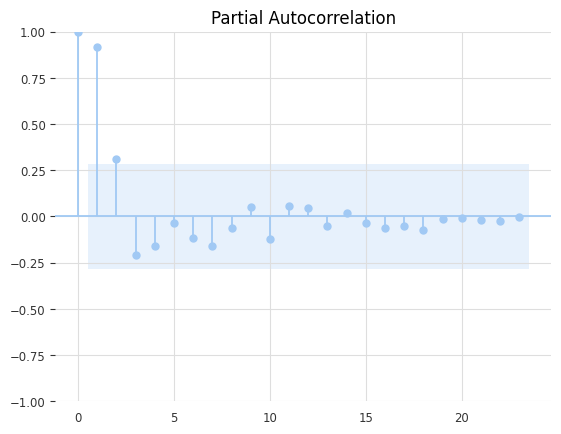

In [145]:
plot_pacf(df_ts_a, lags=23)
pyplot.show()

In [146]:



num_seasons = 4  # Número de estações
f_statistic, p_value = fisher_seasonality_test(df_ts_a, num_seasons)
print("Estatística de teste F:", f_statistic)
print("Valor p:", p_value)


Estatística de teste F: valor_bruto   167.90
dtype: float64
Valor p: [1.11022302e-16]


A estatística de teste F é de 167.90, o que indica uma grande diferença entre as variabilidades dentro e entre as estações.
O valor p associado é de aproximadamente 1.11022302e-16, o que é menor que um nível de significância de 0.05. Portanto, rejeita-se a hipótese nula de que não há diferença significativa na variabilidade entre as estações. Isso sugere que há sazonalidade nos dados.

In [147]:
# Teste Dick Fuller - nesse caso esta em teste a hipótese nula de que há uma raiz unitária na série temporal, indicando não estacionariedade, fator importante para o modelo.
result_sa = adfuller(df_ts_a['valor_bruto'], regression='ct')  # 'ct' para modelo de tendência e componente de tempo
adf_statistic = result_sa[0]
p_value = result_sa[1]
critical_values = result_sa[4]

# Exibir os resultados
print("Estatística ADF:", adf_statistic)
print("Valor p:", p_value)
print("Valores críticos:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

Estatística ADF: -1.955842939116429
Valor p: 0.6252662222208533
Valores críticos:
	1%: -4.1922463983371125
	5%: -3.520758216175359
	10%: -3.1911390346614836


Apesar da estatistica ADF ser mais baixa que os valores criticos, não podemos rejeitar a hipótese nula de não estacionariedade com base neste teste. Isso sugere que a série temporal pode ser não estacionária e pode conter sazonalidade devido ao seu p-valor elevado (0.6252662222208533).

In [148]:
# Teste adf simples para testar a hipotese de nao estacionariedade da serie
result = adfuller(df_ts_a['valor_bruto'])

# Exibir os resultados
print('Estatística ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Estatística ADF: -0.8071134198534718
Valor p: 0.8170236188054885
Valores críticos:
	1%: -3.5925042342183704
	5%: -2.931549768951162
	10%: -2.60406594375338


A estatística ADF está próxima de zero, sugerindo que a evidência contra a hipótese nula de não estacionariedade é fraca. </br>
O valor p é muito alto (0.8170236188054885), indicando que não há evidência suficiente para rejeitar a hipótese nula.</br>
Os valores críticos são maiores que a estatística ADF, o que sugere que não há evidência suficiente contra a hipótese nula.</br>
Por nao poder rejeitar a hipotese nula, entendo que a serie é nao estacionaria.

In [ ]:
# Converter o índice para o tipo de dados datetime
df_ts.index = df_ts.index.to_timestamp()

In [156]:
df_ts_a['valor_bruto'] = df_ts_a['valor_bruto'].astype('float64')
df_ts_a.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 48 entries, 2019-01-31 to 2022-12-31
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   valor_bruto  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


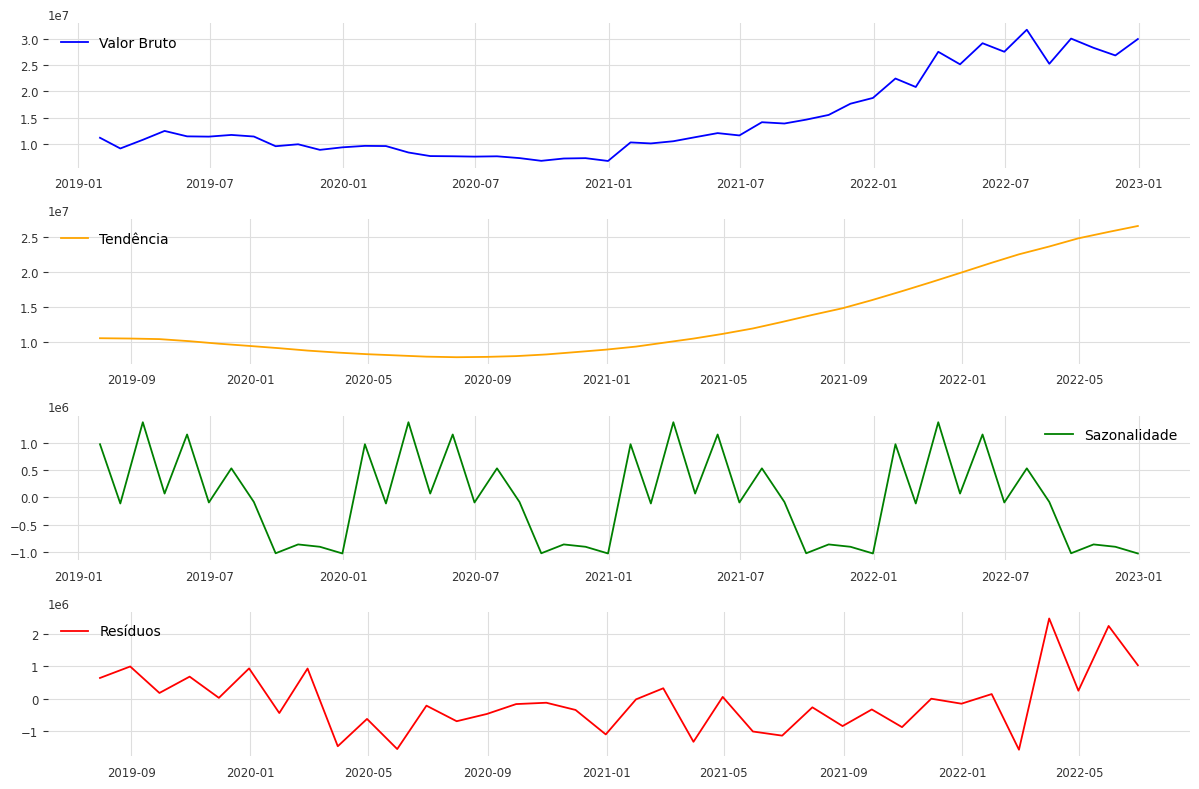

In [160]:
df_ts_a.index = df_ts_a.index.to_timestamp()
# Criar um objeto TimeSeries do statsmodels
ts = sm.tsa.seasonal_decompose(df_ts_a['valor_bruto'], model='additive', period=12)  # Definir o período conforme a frequência dos dados

# Plotar a série temporal e os componentes
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_ts_a['valor_bruto'], label='Valor Bruto', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts.trend, label='Tendência', color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts.seasonal, label='Sazonalidade', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts.resid, label='Resíduos', color='red')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Conforme visto no teste, a série apresenta forte tendencia a partir do ultimo semestre de 2021 sendo confirmada para 2022. </br>
Uma sazonalidade claríssima no primeiro semestre do ano (talvez IPTU, IPVA e outras dívidas levem as pessoas a recorrerem mais a produtos bancários? Não sei, mas é interessante confirmar esses dados com o Marketing/Vendas)</br>
Pela analise dos residuos é possível mapear o comportamento da série, inclusive o aumento das vendas a partir do periodo, bem como a sazonalidade das vendas em algum nivel.


Rodando um ARIMA basico com todos os dados.</br>
Parametros:</br>
p: é a ordem do modelo autoregressivo; Mais especificamente é quantidade de lags(quantidade de valores correlacionados) </br>
d: o número de vezes que as observações serão diferenciadas. </br>
q: é a ordem do modelo de média móvel. </br>

In [244]:
#Modelando um ARIMA básico: (p, q, d)
model = ARIMA(df_ts_a, order=(1,1,1))

In [245]:
model_fit = model.fit()

In [246]:
# summary 
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            valor_bruto   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -744.947
Date:                Sun, 24 Mar 2024   AIC                           1495.894
Time:                        22:00:08   BIC                           1501.445
Sample:                    01-31-2019   HQIC                          1497.983
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6285      0.169     -3.726      0.000      -0.959      -0.298
ma.L1          0.2798      0.237      1.182      0.237      -0.184       0.744
sigma2       3.44e+12   2.16e-14    1.6e+26      0.0

In [247]:
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)

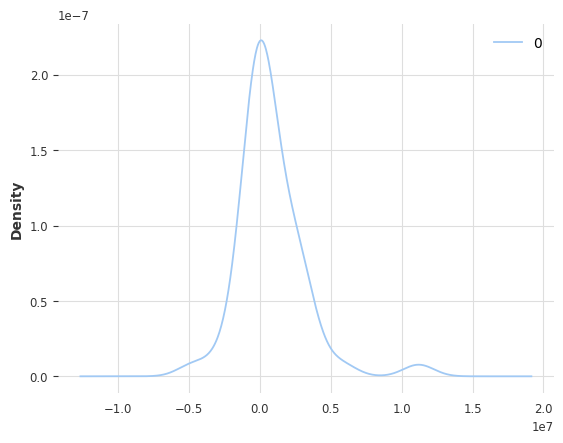

                0
count       48.00
mean    783665.19
std    2338099.69
min   -4704535.17
25%    -299465.75
50%     237443.57
75%    1842149.95
max   11199689.17


In [248]:
# Entendendo os residuos
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

O modelo apresenta uma dispersao consideravel. A media positiva pode indicar que talvez o modelo esteja subestimento valores reais, o desvio padrao é bem alto que indica uma variabilidade grande e a amplitude entre o min e o max também é alta.

In [191]:
X = df_ts_a.values
#garantindo o formato dos dados de entrada
X = X.astype('float')

Para aplicar o modelo ARIMA trabalhando com o m;etodo Walk-Forward. Resumidamente, o Walk-Forward para um modelo ARIMA é uma técnica de validação de séries temporais que atualiza o modelo a cada novo ponto de dados observado. Por isso vou partir o conjunto na metade (50/50). Pontualmente esse metodo faz previsões um passo à frente ao observar novos dados. Isso é repetido até que todos os dados de teste sejam usados, permitindo avaliar continuamente o desempenho do modelo à medida que novos dados são observados.

In [193]:
size = int(len(X) * 0.50)
#treino 50% e teste 50%
train = X[0:size]
test =  X[size:]

In [230]:
# variavel que me permite ter controle para treinar e testar com os dados seguintes
history = [x for x in train]
predictions = list()

In [231]:
from statsmodels.tsa.arima.model import ARIMA
from numpy import log
from sklearn.metrics import mean_squared_error
from math import sqrt

# Inicia Walk-Forward
for t in range(len(test)):
  
    # Difference data
    meses_no_ano = 12
    diff = difference(history, meses_no_ano)
  
    # Cria um modelo ARIMA com os dados de history
    model = ARIMA(diff, order=(3,1,1))
  
    # Treina o modelo ARIMA
    model_fit = model.fit()
  
    # A variável valor_predito recebe o valor previsto pelo modelo
    valor_predito = model_fit.forecast()[0]

    # Valor_predito recebe o valor revertido (escala original)
    valor_predito = inverse_difference(history, valor_predito, meses_no_ano)
   
    # Adiciona o valor predito na lista de predições
    predictions.append(valor_predito)
  
    # A variável valor_real recebe o valor real do teste
    valor_real = test[t]
  
    # Adiciona o valor real à variável history
    history.append(valor_real)

    # Imprime valor predito e valor real
    print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))


Valor predito=7092914.015, Valor esperado=10318386
Valor predito=9919186.008, Valor esperado=10125927
Valor predito=8668677.396, Valor esperado=10542366
Valor predito=10371822.001, Valor esperado=11307236
Valor predito=11606575.429, Valor esperado=12083055
Valor predito=12915994.414, Valor esperado=11642715
Valor predito=12666559.588, Valor esperado=14148726
Valor predito=13936915.482, Valor esperado=13903656
Valor predito=13870631.671, Valor esperado=14637097
Valor predito=15872754.482, Valor esperado=15531533
Valor predito=16234751.731, Valor esperado=17658914
Valor predito=17471818.014, Valor esperado=18753542
Valor predito=22872807.402, Valor esperado=22436811
Valor predito=23633086.834, Valor esperado=20828758
Valor predito=22519947.147, Valor esperado=27504447
Valor predito=26613108.529, Valor esperado=25128277
Valor predito=27780981.660, Valor esperado=29131205
Valor predito=29444462.475, Valor esperado=27516487
Valor predito=31571838.830, Valor esperado=31690328
Valor predito=3

No modelo acima foi utilizada o método de diferenciacao porque a serie nao era estacionaria. 
Foi dividido em 50%/50% e com o walk forward ele vai send treinado e testado com o mes seguinte, sucessivamente. 

In [232]:
# Avaliando os resultados
from numpy import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2320100.847


O teste do RMSE informa que o modelo está errando $2320100.84 para mais ou para menos. Significa que ainda há espaço para melhorar o modelo, reduzindo esse erro até que nao seja mais possivel. É preciso analisar repetidamente e trabalhar os dados até que se atinja um resultado melhor.

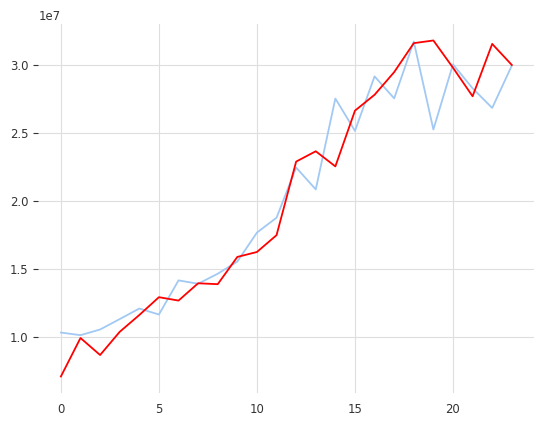

In [233]:
# plot forecasts against actual outcomes 
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Nota-se que o modelo está acertando bem, apesar do erro que está sendo cometido custa caro para os cofres de uma empresa. 
A tendencia seria trabalhar mais esses dados para que o modelo vá melhorando (talvez testar o sarima pela sazonaliizdade acusada), adicionar mais dados, etc.

In [235]:
# erros residuais para verificar se ainda tem a tendencia, sazonalidade, etc. Entender os residuos.
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
# analisando o residuo
residuals.head()

,0
0,3225471.69
1,206740.92
2,1873688.43
3,935413.79
4,476479.39


In [236]:
# em media o modelo esta prevendo valores menores do que os reais, olhando pela media. 
residuals.describe()

,0
count,24.00
mean,-26305.49
std,2369848.86
min,-6538331.05
25%,-645317.25
50%,225722.39
75%,1298849.21
max,4984499.63


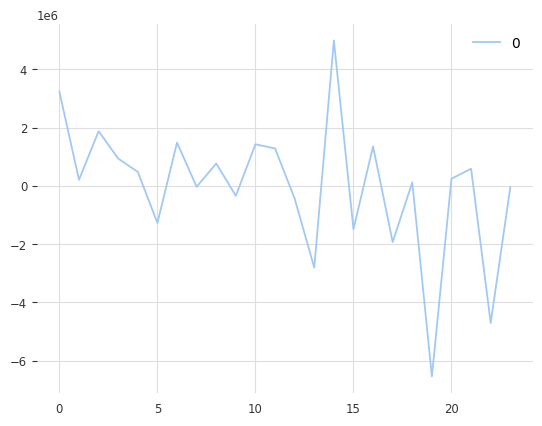

In [238]:
# visualizando os residuos:
residuals.plot()
pyplot.show()

Pelo grafico dos residuos, o modelo caminha bastante proximo ao 0 o que é bom, mas apresentou algumas derrapadas formando spikes bem altos. Numa busca por melhoria dos modelos, isso seria avaliado de forma mais profunda.

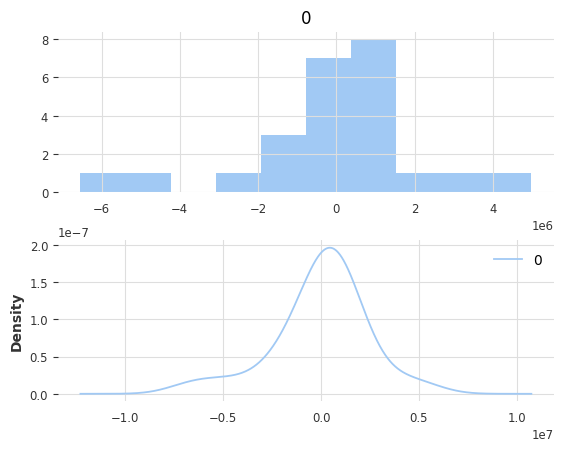

In [239]:
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())

pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Como visto no grafico anterior, os graficos apresentam certa aleatoriedade, o que é positivo e indica que o problema da sazonalidade e da estacionariedade da serie foi sanado. A cauda está ligeiramente mais pesada na esquerda mas nao é significativo.

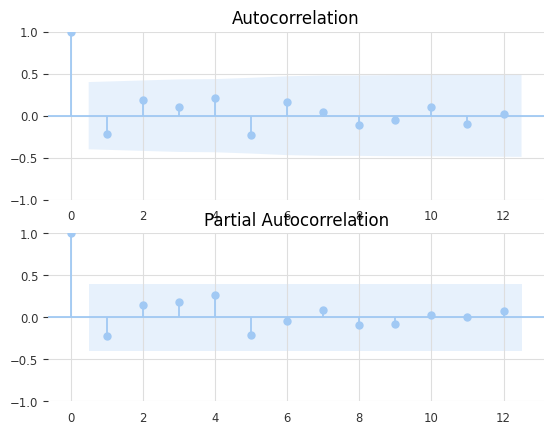

In [240]:
# plots de autocorrelação
pyplot.figure() 
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

Os graficos mostram que existe a autocorrelacao mas elas nao foram significativas. O modelo performou bem, apesar do espaço para melhorias. 

In [251]:
# Hiistorico dos dados
history_full = history + predictions

# Predicao 2023
predictions_12_months = []
for _ in range(12):
    # adicionar a diferença
    diff = difference(history_full, meses_no_ano)
    
    # modelo ARIMA treinando
    model = ARIMA(diff, order=(3, 1, 1))
    model_fit = model.fit()
    
    # A previsão para o próximo ponto
    valor_predito = model_fit.forecast()[0]
    
    # Reverte a diferença para a escala original
    valor_predito = inverse_difference(history_full, valor_predito, meses_no_ano)
    
    # Adiciona a previsão à lista de previsões
    predictions_12_months.append(valor_predito)
    
    # Atualiza o histórico completo com a previsão feita
    history_full.append(valor_predito)

# Previsoa para os proximos 24 meses
predictions_24_months = []
for _ in range(12):
    # Diferenças
    diff = difference(history_full, meses_no_ano)
    
    # Modelo trainando
    model = ARIMA(diff, order=(3, 1, 1))
    model_fit = model.fit()
    
    # Faz a previsão para o próximo ponto
    valor_predito = model_fit.forecast()[0]
    
    # Reverte a diferença para a escala original
    valor_predito = inverse_difference(history_full, valor_predito, meses_no_ano)
    
    # Adiciona a previsão à lista de previsões
    predictions_24_months.append(valor_predito)
    
    # Atualiza o histórico completo com a previsão feita
    history_full.append(valor_predito)


In [250]:
# Imprimir as previsões
print("Previsão para os próximos 12 meses (2023):", predictions_12_months)
print("Previsão para os próximos 24 meses (2024):", predictions_24_months)

Previsão para os próximos 12 meses (2023): [array([36451430.51189546]), array([36833191.09517626]), array([35564435.23372372]), array([39877915.8254974]), array([40831019.63798078]), array([42613205.49551547]), array([44684032.45202077]), array([44888342.88251338]), array([42896516.97825769]), array([40785060.15237296]), array([44641373.11465508]), array([43089721.22585912])]
Previsão para os próximos 24 meses (2024): [array([49573062.27743708]), array([49954587.00056951]), array([48685161.87532376]), array([52999380.0696753]), array([53951939.65355443]), array([55734405.68718632]), array([57805135.42718937]), array([58009439.55647392]), array([56017654.1487007]), array([53906156.42333054]), array([57762496.36939054]), array([56210831.22562859])]


In [256]:
predictions_df

,0,Previsão_2024
0,36451430.51,[49573062.27743708]
1,36833191.10,[49954587.00056951]
2,35564435.23,[48685161.875323765]
3,39877915.83,[52999380.0696753]
4,40831019.64,[53951939.65355443]
5,42613205.50,[55734405.687186316]
6,44684032.45,[57805135.42718937]
7,44888342.88,[58009439.55647392]
8,42896516.98,[56017654.1487007]
9,40785060.15,[53906156.42333054]


<Axes: title={'center': 'Previsão de Valores Brutos para 2023 e 2024'}, xlabel='Previsão_2024'>

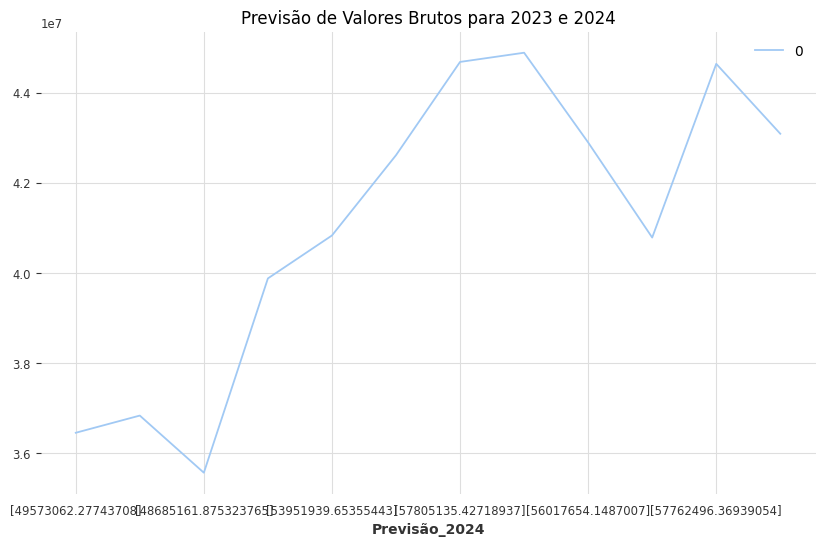

In [258]:
# Converter as listas de previsões em um DataFrame
predictions_df = pd.DataFrame(predictions_12_months)

# Adicionar as previsões dos próximos 12 meses
predictions_df['Previsão_2024'] = predictions_24_months

# Configurar a coluna 'Data' como o índice
predictions_df.set_index('Previsão_2024', inplace=True)

# Plotar os gráficos
predictions_df.plot(title='Previsão de Valores Brutos para 2023 e 2024', figsize=(10, 6))
